In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.optimize import linear_sum_assignment
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
# Load data
loaded_df = pd.read_hdf('../data/sample_otu_arrays.h5', key='df')

# Set random seed
np.random.seed(42)

# Split indices into train/test
train_idx, test_idx = train_test_split(loaded_df.index, test_size=0.2, random_state=42)

# Create train and test dataframes
train_df = loaded_df.loc[train_idx]
test_df = loaded_df.loc[test_idx]

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
print("\nFirst few training samples:")
print(train_df.head())

# Let's also look at array lengths
array_lengths = [len(x) for x in loaded_df['otu_arrays']]
print(f"\nMin array length: {min(array_lengths)}")
print(f"Max array length: {max(array_lengths)}")
print(f"Mean array length: {np.mean(array_lengths):.2f}")

Train size: 6486
Test size: 1622

First few training samples:
                                                            otu_arrays
Unnamed: 0                                                            
SRR044975.SRS011167  [30, 58, 82, 89, 93, 98, 99, 104, 117, 120, 12...
SRR049604.SRS049164  [9, 10, 11, 14, 15, 16, 17, 20, 28, 30, 31, 32...
SRR331714.SRS076947  [19, 30, 43, 58, 65, 70, 71, 74, 80, 90, 92, 9...
SRR089999.SRS077685  [12, 14, 18, 20, 22, 38, 45, 67, 68, 76, 88, 1...
SRR048091.SRS021563  [19, 30, 45, 52, 58, 60, 65, 70, 74, 80, 90, 9...

Min array length: 3
Max array length: 277
Mean array length: 69.10


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

class OTUDataset(Dataset):
    def __init__(self, df, pad_token_id=0):
        self.df = df
        self.pad_token_id = pad_token_id
        
        # Find max sequence length for padding
        self.max_len = max(len(x) for x in df['otu_arrays'])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        array = self.df.iloc[idx]['otu_arrays']
        
        # Create padded sequence
        padded = torch.full((self.max_len,), self.pad_token_id, dtype=torch.long)
        padded[:len(array)] = torch.tensor(array, dtype=torch.long)
        
        # Create padding mask (False for real tokens, True for padding)
        # This matches the convention used in transformers where
        # True indicates positions that should be masked
        padding_mask = torch.zeros(self.max_len, dtype=torch.bool)
        padding_mask[len(array):] = True
        
        return {
            'input_ids': padded,
            'padding_mask': padding_mask,
            'seq_len': len(array)
        }

# Create datasets
train_dataset = OTUDataset(train_df, pad_token_id=0)
test_dataset = OTUDataset(test_df, pad_token_id=0)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify shapes
for i in train_loader:
   print(i['input_ids'].shape)
   print(i['padding_mask'].shape)
   print(i['seq_len'])
   break

# Get vocab size (maximum token ID + 1 for padding)
vocab_size = max(max(x) for x in loaded_df['otu_arrays']) + 1
print(f"\nVocabulary size: {vocab_size}")

torch.Size([32, 277])
torch.Size([32, 277])
tensor([ 23,  91,  16, 122,  65, 111,  67,  71,  74, 112, 132,  95,  33,  95,
         96,  19, 111,  91, 121,  75,  74,  74,  98,  65,  29,  85,  82, 118,
         38,  12,  93,  75])

Vocabulary size: 519


In [4]:
import importlib
import cdcdModel
import scheduler
importlib.reload(cdcdModel)
importlib.reload(scheduler)

from cdcdModel import CDCDModel
from scheduler import AdaptiveSchedule

In [5]:
def train_step(model, batch, scheduler, optimizer):
    """Single training step for CDCD model
    
    Args:
        model: CDCDModel instance
        batch: Dictionary containing:
            - input_ids: [batch_size, seq_len] tensor of token ids
            - padding_mask: [batch_size, seq_len] boolean tensor (True for padding)
        scheduler: AdaptiveSchedule instance
        optimizer: PyTorch optimizer
    
    Returns:
        loss: scalar training loss
        entropy: entropy statistics for scheduler
    """
    # Get batch data
    input_ids = batch['input_ids']
    padding_mask = batch['padding_mask']
    batch_size, seq_len = input_ids.shape
    
    # Sample random timesteps for training
    timesteps = scheduler.sample((batch_size,)).to(input_ids.device)  # Shape: [batch_size]
   
    
    # Forward pass through model
    logits = model(
        input_ids,
        timesteps=timesteps,
        training=True,
        padding_mask=padding_mask
    )
    
    # Calculate cross entropy loss (ignoring padding)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)  # Assuming 0 is pad_token_id
    loss = loss_fn(
        logits.view(-1, logits.size(-1)),
        input_ids.view(-1)
    )
    
    # Calculate entropy for scheduler
    with torch.no_grad():
        probs = F.softmax(logits, dim=-1)
        
        # Add small epsilon to prevent log(0)
        eps = 1e-8
        probs = torch.clamp(probs, min=eps, max=1-eps)
        
        entropy = -(probs * torch.log(probs)).sum(dim=-1)  # [batch_size, seq_len]
        
        # Expand timesteps to match sequence dimension
        timesteps_expanded = timesteps.unsqueeze(-1).expand(-1, seq_len)
        
        # Add entropy data to scheduler (excluding padding)
        scheduler.add_data(
            entropy[~padding_mask],
            timesteps_expanded[~padding_mask],
            padding_mask=None  # Already filtered padding
        )
    
    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item(), entropy.mean().item()

def eval_step(model, batch):
    """Single evaluation step for CDCD model
    
    Args:
        model: CDCDModel instance
        batch: Dictionary containing input_ids and padding_mask
        
    Returns:
        loss: scalar evaluation loss
        entropy: entropy statistics
    """
    # Get batch data
    input_ids = batch['input_ids']
    padding_mask = batch['padding_mask']
    batch_size, seq_len = input_ids.shape
    
    # Use middle timestep for evaluation (or could sample uniformly)
    timesteps = scheduler.sample((batch_size,)).to(input_ids.device)
    
    # Forward pass through model
    logits = model(
        input_ids,
        timesteps=timesteps,
        training=False,
        padding_mask=padding_mask
    )
    
    # Calculate cross entropy loss (ignoring padding)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)
    loss = loss_fn(
        logits.view(-1, logits.size(-1)),
        input_ids.view(-1)
    )
    
    # Calculate entropy
    probs = F.softmax(logits, dim=-1)
    eps = 1e-8
    probs = torch.clamp(probs, min=eps, max=1-eps)
    entropy = -(probs * torch.log(probs)).sum(dim=-1)
    
    return loss.item(), entropy.mean().item()

In [6]:
def run_epoch(model, dataloader, scheduler, optimizer, train_run=True, epoch_num=None):
    """Runs one epoch of training or evaluation for the CDCD model"""
    model.train() if train_run else model.eval()
    total_loss = 0
    total_entropy = 0
    num_batches = 0
    
    # Setup progress bar
    mode = "Train" if train_run else "Eval"
    epoch_str = f"Epoch {epoch_num}" if epoch_num is not None else mode
    pbar = tqdm(total=len(dataloader), desc=f"{epoch_str} Loss: 0.0000, Entropy: 0.0000")
    device = next(model.parameters()).device

    # Main loop
    for batch in dataloader:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        if train_run:
            loss, entropy = train_step(model, batch, scheduler, optimizer)
        else:
            # Use separate eval step without optimizer/scheduler
            loss, entropy = eval_step(model, batch)
        
        # Accumulate metrics
        total_loss += loss
        total_entropy += entropy
        num_batches += 1
        
        # Update progress bar
        avg_loss = total_loss / num_batches
        avg_entropy = total_entropy / num_batches
        pbar.set_description(f"{epoch_str} Loss: {avg_loss:.4f}, Entropy: {avg_entropy:.4f}")
        pbar.update(1)
    
    pbar.close()
    
    # Calculate final averages
    avg_loss = total_loss / num_batches
    avg_entropy = total_entropy / num_batches
    
    # Update scheduler parameters if training
    if train_run:
        scheduler.update_optimal_parameters(history=10_000)
    
    return {
        "loss": avg_loss,
        "entropy": avg_entropy,
        "num_batches": num_batches
    }

In [222]:
def train(
    model,
    train_dataloader,
    eval_dataloader,
    noise_scheduler,
    num_epochs,
    initial_lr=1e-4,
    min_lr=1e-6,
    first_cycle_epochs=30,
    cycle_mult=2,
    eval_every=1,
    early_stopping_patience=5,
    save_dir="checkpoints",
    device="cuda",
):
    """Trains the CDCD model using Cosine Annealing with Warm Restarts
    
    Args:
        model: CDCDModel instance
        train_dataloader: DataLoader for training data
        eval_dataloader: DataLoader for evaluation data
        noise_scheduler: Noise scheduler for diffusion process
        num_epochs: Number of epochs to train for
        initial_lr: Initial learning rate
        min_lr: Minimum learning rate
        first_cycle_epochs: Length of first cosine cycle
        cycle_mult: Factor to multiply cycle length by after each restart
        eval_every: Number of epochs between evaluation runs
        early_stopping_patience: Number of epochs to wait for improvement before stopping
        save_dir: Directory to save model checkpoints
        device: Device to train on
    """
    import torch
    from torch.optim import lr_scheduler
    from pathlib import Path
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr)
    lr_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=first_cycle_epochs,
        T_mult=cycle_mult,
        eta_min=min_lr
    )
    
    best_eval_loss = float('inf')
    best_epoch = 0
    epochs_without_improvement = 0
    train_losses = []
    eval_losses = []
    learning_rates = []
    
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    model = model.to(device)
    
    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"\nEpoch {epoch+1}/{num_epochs} - Learning Rate: {current_lr:.6f}")
        
        # Training phase
        train_metrics = run_epoch(
            model=model,
            dataloader=train_dataloader,
            scheduler=noise_scheduler,
            optimizer=optimizer,
            train_run=True,
            epoch_num=epoch+1
        )
        train_losses.append(train_metrics['loss'])
        
        # Evaluation phase
        if (epoch + 1) % eval_every == 0:
            eval_metrics = run_epoch(
                model=model,
                dataloader=eval_dataloader,
                scheduler=noise_scheduler,
                optimizer=optimizer,
                train_run=False,
                epoch_num=epoch+1
            )
            eval_losses.append(eval_metrics['loss'])
            
            # Save best model and handle early stopping
            if eval_metrics['loss'] < best_eval_loss:
                best_eval_loss = eval_metrics['loss']
                best_epoch = epoch
                epochs_without_improvement = 0
                
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': lr_scheduler.state_dict(),
                    'noise_scheduler_state': noise_scheduler.state_dict(),
                    'loss': best_eval_loss,
                }, save_dir / 'best_model.pt')
            else:
                epochs_without_improvement += 1
            print('-'*16)
            print(f"Eval Loss: {eval_metrics['loss']:.4f}")
            print(f"Best Loss: {best_eval_loss:.4f} (Epoch {best_epoch+1})")
            
            if epochs_without_improvement >= early_stopping_patience:
                print(f"\nEarly stopping triggered after {epoch+1} epochs")
                break
        
        # Update learning rate
        lr_scheduler.step()
        learning_rates.append(current_lr)
        
        # Save periodic checkpoint
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': lr_scheduler.state_dict(),
                'noise_scheduler_state': noise_scheduler.state_dict(),
                'loss': train_metrics['loss'],
            }, save_dir / f'checkpoint_epoch_{epoch+1}.pt')
    
    # Load best model
    best_checkpoint = torch.load(save_dir / 'best_model.pt')
    model.load_state_dict(best_checkpoint['model_state_dict'])
    
    return {
        'train_losses': train_losses,
        'eval_losses': eval_losses,
        'best_epoch': best_epoch,
        'learning_rates': learning_rates
    }

In [224]:
# Model hyperparameters
hidden_dim = 32  # Dimension of hidden layers
embedding_dim = 32  # Dimension of embeddings
num_heads = 8  # Number of attention heads
num_layers = 4  # Number of transformer layers
time_embed_dim = 32  # Dimension of time embeddings
t_min = 1 # Minimum time value
t_max = 25  # To high breaks scheduler. This value really depends on embed dim: SNR = ed/t^2. if ed = 32, tmax=25 ~ 0 SNR
vocab_size = 519

model = CDCDModel(
    hidden_dim = hidden_dim,
    embedding_dim = embedding_dim,
    num_heads = num_heads,
    num_layers = num_layers,
    time_embed_dim = time_embed_dim,
    t_min = t_min,
    t_max = t_max,
    vocab_size = vocab_size,
    dropout=0.1,
    pad_token_id=0
)

scheduler = AdaptiveSchedule(
    tmin = t_min,
    tmax = t_max,
    mu = 12.5,
    sigma = 8,
    height = 1,
    offset = 0.1
)

In [225]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [226]:

for batch in train_loader:
# Move batch to device
    batch = {k: v.to(device) for k, v in batch.items()}
    train_step(model,batch, scheduler, optimizer)
    break

In [234]:
model.self_conditioner.prev_preds = None

In [235]:
training_history = train(
    model=model,
    train_dataloader=train_loader,
    eval_dataloader=test_loader,
    noise_scheduler=scheduler,
    num_epochs=40,
    initial_lr=1e-3,
    min_lr=1e-8,
    first_cycle_epochs=4,  # Length of first cosine cycle
    cycle_mult=2,  # Each subsequent cycle is twice as long
    eval_every=5,
    early_stopping_patience=20,
    save_dir="checkpoints"
)


Epoch 1/40 - Learning Rate: 0.001000

































































































































































































































































Epoch 1 Loss: 3.4270, Entropy: 5.1758: 100%|██████████| 203/203 [00:06<00:00, 32.69it/s]
2025-02-11 15:28:39,321 - INFO - Updated optimal parameters: mu=1.9970674251961877, sigma=1.3648611567825963, height=6.513148416855919, offset=-0.7456213539560393



Epoch 2/40 - Learning Rate: 0.000854
































































































































































































































































Epoch 2 Loss: 3.4775, Entropy: 5.1811: 100%|██████████| 203/203 [00:06<00:00, 33.10it/s]
2025-02-11 15:28:45,471 - INFO - Updated optimal parameters: mu=1.840776042723802, sigma=1.3990583620718466, height=7.05267007622061, offset=-1.2429250185755636



Epoch 3/40 - Learning Rate: 0.000500
































































































































































































































































Epoch 3 Loss: 3.4339, Entropy: 5.1683: 100%|██████████| 203/203 [00:06<00:00, 33.12it/s]
2025-02-11 15:28:51,617 - INFO - Updated optimal parameters: mu=1.7425867927944796, sigma=1.509407704660928, height=7.369656646406586, offset=-1.458969669983093



Epoch 4/40 - Learning Rate: 0.000146
































































































































































































































































Epoch 4 Loss: 3.4294, Entropy: 5.1683: 100%|██████████| 203/203 [00:06<00:00, 33.19it/s]
2025-02-11 15:28:57,756 - INFO - Updated optimal parameters: mu=1.81206229447689, sigma=1.396609456989304, height=7.304829657705069, offset=-1.401983187721185



Epoch 5/40 - Learning Rate: 0.001000
































































































































































































































































Epoch 5 Loss: 3.4192, Entropy: 5.1606: 100%|██████████| 203/203 [00:06<00:00, 33.15it/s]
2025-02-11 15:29:03,896 - INFO - Updated optimal parameters: mu=1.7745620555213923, sigma=1.4219917742389636, height=7.234141812400524, offset=-1.38803419544508
























































Epoch 5 Loss: 3.4583, Entropy: 5.0705: 100%|██████████| 51/51 [00:00<00:00, 103.22it/s]


----------------
Eval Loss: 3.4583
Best Loss: 3.4583 (Epoch 5)

Epoch 6/40 - Learning Rate: 0.000962
































































































































































































































































Epoch 6 Loss: 3.3527, Entropy: 5.1350: 100%|██████████| 203/203 [00:06<00:00, 31.63it/s]
2025-02-11 15:29:10,911 - INFO - Updated optimal parameters: mu=1.7145224706035573, sigma=1.5773728127375497, height=7.489033201638627, offset=-1.5555771643047636



Epoch 7/40 - Learning Rate: 0.000854
































































































































































































































































Epoch 7 Loss: 3.4411, Entropy: 5.1489: 100%|██████████| 203/203 [00:06<00:00, 31.33it/s]
2025-02-11 15:29:17,411 - INFO - Updated optimal parameters: mu=1.699802700371516, sigma=1.4687119483003936, height=7.608835417926838, offset=-1.7729984746239873



Epoch 8/40 - Learning Rate: 0.000691
































































































































































































































































Epoch 8 Loss: 3.3751, Entropy: 5.1300: 100%|██████████| 203/203 [00:06<00:00, 30.61it/s]
2025-02-11 15:29:24,058 - INFO - Updated optimal parameters: mu=1.6175115930443011, sigma=1.6201586757168507, height=7.619435623882616, offset=-1.7258785784495372



Epoch 9/40 - Learning Rate: 0.000500
































































































































































































































































Epoch 9 Loss: 3.4593, Entropy: 5.1488: 100%|██████████| 203/203 [00:06<00:00, 31.45it/s]
2025-02-11 15:29:30,529 - INFO - Updated optimal parameters: mu=1.937103245181336, sigma=1.361427244323504, height=7.147522431928818, offset=-1.2590008905651833



Epoch 10/40 - Learning Rate: 0.000309
































































































































































































































































Epoch 10 Loss: 3.4178, Entropy: 5.1382: 100%|██████████| 203/203 [00:06<00:00, 32.79it/s]
2025-02-11 15:29:36,738 - INFO - Updated optimal parameters: mu=1.855525698722787, sigma=1.510914970176022, height=7.3077916422995495, offset=-1.3937733849006764
























































Epoch 10 Loss: 3.5347, Entropy: 5.0724: 100%|██████████| 51/51 [00:00<00:00, 103.11it/s]


----------------
Eval Loss: 3.5347
Best Loss: 3.4583 (Epoch 5)

Epoch 11/40 - Learning Rate: 0.000146
































































































































































































































































Epoch 11 Loss: 3.4568, Entropy: 5.1472: 100%|██████████| 203/203 [00:06<00:00, 33.08it/s]
2025-02-11 15:29:43,456 - INFO - Updated optimal parameters: mu=1.7679902597974873, sigma=1.3638479978560625, height=7.493461164737529, offset=-1.5896554271999326



Epoch 12/40 - Learning Rate: 0.000038
































































































































































































































































Epoch 12 Loss: 3.3422, Entropy: 5.1234: 100%|██████████| 203/203 [00:06<00:00, 32.95it/s]
2025-02-11 15:29:49,632 - INFO - Updated optimal parameters: mu=1.7639892759040134, sigma=1.3180802294877492, height=7.309040288396691, offset=-1.5672576947295782



Epoch 13/40 - Learning Rate: 0.001000
































































































































































































































































Epoch 13 Loss: 3.3121, Entropy: 5.1079: 100%|██████████| 203/203 [00:06<00:00, 32.22it/s]
2025-02-11 15:29:55,946 - INFO - Updated optimal parameters: mu=1.8681026158875518, sigma=1.2796558344553781, height=7.046247755855304, offset=-1.2129314432005238



Epoch 14/40 - Learning Rate: 0.000990
































































































































































































































































Epoch 14 Loss: 3.3341, Entropy: 5.1018: 100%|██████████| 203/203 [00:06<00:00, 31.36it/s]
2025-02-11 15:30:02,437 - INFO - Updated optimal parameters: mu=1.7931955053053443, sigma=1.3740164803393655, height=7.199752419863101, offset=-1.3470569839834716



Epoch 15/40 - Learning Rate: 0.000962
































































































































































































































































Epoch 15 Loss: 3.3615, Entropy: 5.0996: 100%|██████████| 203/203 [00:06<00:00, 31.37it/s]
2025-02-11 15:30:08,925 - INFO - Updated optimal parameters: mu=1.7206952012305425, sigma=1.4857013303641433, height=7.31403855576101, offset=-1.4983783472735819
























































Epoch 15 Loss: 3.4344, Entropy: 5.0214: 100%|██████████| 51/51 [00:00<00:00, 104.65it/s]


----------------
Eval Loss: 3.4344
Best Loss: 3.4344 (Epoch 15)

Epoch 16/40 - Learning Rate: 0.000916
































































































































































































































































Epoch 16 Loss: 3.3945, Entropy: 5.1006: 100%|██████████| 203/203 [00:06<00:00, 31.19it/s]
2025-02-11 15:30:16,001 - INFO - Updated optimal parameters: mu=1.7634687927260435, sigma=1.5290179583727646, height=7.565660703184446, offset=-1.6495866358651612



Epoch 17/40 - Learning Rate: 0.000854
































































































































































































































































Epoch 17 Loss: 3.4403, Entropy: 5.1077: 100%|██████████| 203/203 [00:06<00:00, 31.07it/s]
2025-02-11 15:30:22,549 - INFO - Updated optimal parameters: mu=1.903748184750194, sigma=1.5018662047875984, height=7.25576484983811, offset=-1.2891587070877173



Epoch 18/40 - Learning Rate: 0.000778
































































































































































































































































Epoch 18 Loss: 3.4706, Entropy: 5.1127: 100%|██████████| 203/203 [00:06<00:00, 31.44it/s]
2025-02-11 15:30:29,022 - INFO - Updated optimal parameters: mu=1.7833316496698703, sigma=1.641718647415532, height=7.510894676288789, offset=-1.5426519851533647



Epoch 19/40 - Learning Rate: 0.000691
































































































































































































































































Epoch 19 Loss: 3.5191, Entropy: 5.1230: 100%|██████████| 203/203 [00:06<00:00, 31.35it/s]
2025-02-11 15:30:35,515 - INFO - Updated optimal parameters: mu=1.806365370785696, sigma=1.3922807327393785, height=7.29320186457685, offset=-1.375138116027737



Epoch 20/40 - Learning Rate: 0.000598
































































































































































































































































Epoch 20 Loss: 3.3293, Entropy: 5.0782: 100%|██████████| 203/203 [00:06<00:00, 31.33it/s]
2025-02-11 15:30:42,012 - INFO - Updated optimal parameters: mu=1.7542825840459964, sigma=1.3077048147390304, height=7.217493931742435, offset=-1.5244302574289235
























































Epoch 20 Loss: 3.4005, Entropy: 5.0115: 100%|██████████| 51/51 [00:00<00:00, 100.90it/s]


----------------
Eval Loss: 3.4005
Best Loss: 3.4005 (Epoch 20)

Epoch 21/40 - Learning Rate: 0.000500
































































































































































































































































Epoch 21 Loss: 3.2200, Entropy: 5.0489: 100%|██████████| 203/203 [00:06<00:00, 32.63it/s]
2025-02-11 15:30:48,813 - INFO - Updated optimal parameters: mu=1.7786992379389397, sigma=1.505631349901638, height=7.3850679463095545, offset=-1.4716534232918683



Epoch 22/40 - Learning Rate: 0.000402
































































































































































































































































Epoch 22 Loss: 3.3741, Entropy: 5.0813: 100%|██████████| 203/203 [00:06<00:00, 32.87it/s]
2025-02-11 15:30:55,007 - INFO - Updated optimal parameters: mu=1.7767826952254464, sigma=1.2077865859448422, height=7.366096687607113, offset=-1.6512687613401693



Epoch 23/40 - Learning Rate: 0.000309
































































































































































































































































Epoch 23 Loss: 3.1667, Entropy: 5.0350: 100%|██████████| 203/203 [00:05<00:00, 34.00it/s]
2025-02-11 15:31:00,993 - INFO - Updated optimal parameters: mu=1.7757347503416672, sigma=1.3234942274805812, height=7.154430901062994, offset=-1.3998168094132062



Epoch 24/40 - Learning Rate: 0.000222
































































































































































































































































Epoch 24 Loss: 3.2534, Entropy: 5.0526: 100%|██████████| 203/203 [00:06<00:00, 33.74it/s]
2025-02-11 15:31:07,028 - INFO - Updated optimal parameters: mu=1.7910523181867721, sigma=1.4755508696259274, height=7.312068181558801, offset=-1.458628448325842



Epoch 25/40 - Learning Rate: 0.000146
































































































































































































































































Epoch 25 Loss: 3.3596, Entropy: 5.0752: 100%|██████████| 203/203 [00:06<00:00, 31.47it/s]
2025-02-11 15:31:13,497 - INFO - Updated optimal parameters: mu=1.7520412903084817, sigma=1.3629793326493675, height=7.402442926638096, offset=-1.603912672627225
























































Epoch 25 Loss: 3.4184, Entropy: 5.0204: 100%|██████████| 51/51 [00:00<00:00, 103.67it/s]


----------------
Eval Loss: 3.4184
Best Loss: 3.4005 (Epoch 20)

Epoch 26/40 - Learning Rate: 0.000084
































































































































































































































































Epoch 26 Loss: 3.2751, Entropy: 5.0570: 100%|██████████| 203/203 [00:06<00:00, 31.19it/s]
2025-02-11 15:31:20,515 - INFO - Updated optimal parameters: mu=1.8641037339552735, sigma=1.4554615410185894, height=7.443060373594546, offset=-1.5282654232462647



Epoch 27/40 - Learning Rate: 0.000038
































































































































































































































































Epoch 27 Loss: 3.3809, Entropy: 5.0805: 100%|██████████| 203/203 [00:06<00:00, 32.77it/s]
2025-02-11 15:31:26,727 - INFO - Updated optimal parameters: mu=1.8084692558910993, sigma=1.3435160804154984, height=7.420166600546579, offset=-1.5705739283722937



Epoch 28/40 - Learning Rate: 0.000010
































































































































































































































































Epoch 28 Loss: 3.2663, Entropy: 5.0538: 100%|██████████| 203/203 [00:06<00:00, 33.11it/s]
2025-02-11 15:31:32,872 - INFO - Updated optimal parameters: mu=1.9361580925455268, sigma=1.4360975275102938, height=7.30256422777443, offset=-1.398324898001881



Epoch 29/40 - Learning Rate: 0.001000
































































































































































































































































Epoch 29 Loss: 3.4530, Entropy: 5.0924: 100%|██████████| 203/203 [00:06<00:00, 33.08it/s]
2025-02-11 15:31:39,025 - INFO - Updated optimal parameters: mu=1.7620711240130753, sigma=1.419973668044588, height=7.324808805790388, offset=-1.4834455230907453



Epoch 30/40 - Learning Rate: 0.000998
































































































































































































































































Epoch 30 Loss: 3.3684, Entropy: 5.0670: 100%|██████████| 203/203 [00:06<00:00, 33.21it/s]
2025-02-11 15:31:45,158 - INFO - Updated optimal parameters: mu=1.8049997744845545, sigma=1.5152303053032605, height=7.44860602062526, offset=-1.5814984375374914
























































Epoch 30 Loss: 3.5342, Entropy: 5.0301: 100%|██████████| 51/51 [00:00<00:00, 100.85it/s]


----------------
Eval Loss: 3.5342
Best Loss: 3.4005 (Epoch 20)

Epoch 31/40 - Learning Rate: 0.000990
































































































































































































































































Epoch 31 Loss: 3.4065, Entropy: 5.0683: 100%|██████████| 203/203 [00:06<00:00, 33.24it/s]
2025-02-11 15:31:51,817 - INFO - Updated optimal parameters: mu=1.7317612891171406, sigma=1.4640135321790981, height=7.402417519527811, offset=-1.5357151008034373



Epoch 32/40 - Learning Rate: 0.000978
































































































































































































































































Epoch 32 Loss: 3.3672, Entropy: 5.0527: 100%|██████████| 203/203 [00:06<00:00, 33.08it/s]
2025-02-11 15:31:57,971 - INFO - Updated optimal parameters: mu=1.7268055791093857, sigma=1.3701278160921275, height=7.485465726662378, offset=-1.653652426659799



Epoch 33/40 - Learning Rate: 0.000962
































































































































































































































































Epoch 33 Loss: 3.2834, Entropy: 5.0286: 100%|██████████| 203/203 [00:06<00:00, 32.51it/s]
2025-02-11 15:32:04,231 - INFO - Updated optimal parameters: mu=1.7411289968410408, sigma=1.365366263811717, height=7.3098699014494715, offset=-1.5981518658244591



Epoch 34/40 - Learning Rate: 0.000941
































































































































































































































































Epoch 34 Loss: 3.2687, Entropy: 5.0157: 100%|██████████| 203/203 [00:06<00:00, 31.31it/s]
2025-02-11 15:32:10,732 - INFO - Updated optimal parameters: mu=1.6315487649897176, sigma=1.3358601216548764, height=7.2459910504861265, offset=-1.5473772307056923



Epoch 35/40 - Learning Rate: 0.000916
































































































































































































































































Epoch 35 Loss: 3.2199, Entropy: 4.9990: 100%|██████████| 203/203 [00:06<00:00, 31.37it/s]
2025-02-11 15:32:17,219 - INFO - Updated optimal parameters: mu=1.8142827754052238, sigma=1.6459712298553066, height=7.471679013982058, offset=-1.582424753845722
























































Epoch 35 Loss: 3.5808, Entropy: 5.0301: 100%|██████████| 51/51 [00:00<00:00, 104.37it/s]


----------------
Eval Loss: 3.5808
Best Loss: 3.4005 (Epoch 20)

Epoch 36/40 - Learning Rate: 0.000887
































































































































































































































































Epoch 36 Loss: 3.4958, Entropy: 5.0548: 100%|██████████| 203/203 [00:06<00:00, 31.25it/s]
2025-02-11 15:32:24,221 - INFO - Updated optimal parameters: mu=1.691800386438453, sigma=1.570395845788518, height=7.621862794141083, offset=-1.7523266028196587



Epoch 37/40 - Learning Rate: 0.000854
































































































































































































































































Epoch 37 Loss: 3.3859, Entropy: 5.0318: 100%|██████████| 203/203 [00:06<00:00, 31.02it/s]
2025-02-11 15:32:30,784 - INFO - Updated optimal parameters: mu=1.7040202475520845, sigma=1.6095184411985421, height=7.695581692063913, offset=-1.815218085698611



Epoch 38/40 - Learning Rate: 0.000817
































































































































































































































































Epoch 38 Loss: 3.4245, Entropy: 5.0372: 100%|██████████| 203/203 [00:06<00:00, 31.07it/s]
2025-02-11 15:32:37,336 - INFO - Updated optimal parameters: mu=1.6484355985946553, sigma=1.4913665993657799, height=7.68970815405146, offset=-1.8540525756957098



Epoch 39/40 - Learning Rate: 0.000778
































































































































































































































































Epoch 39 Loss: 3.2683, Entropy: 4.9991: 100%|██████████| 203/203 [00:06<00:00, 31.09it/s]
2025-02-11 15:32:43,883 - INFO - Updated optimal parameters: mu=1.7412923851771056, sigma=1.2920416855050776, height=7.57201340427203, offset=-1.8000820206580508



Epoch 40/40 - Learning Rate: 0.000736
































































































































































































































































Epoch 40 Loss: 3.2295, Entropy: 4.9850: 100%|██████████| 203/203 [00:06<00:00, 31.03it/s]
2025-02-11 15:32:50,441 - INFO - Updated optimal parameters: mu=1.8523014576347085, sigma=1.5181287743083218, height=7.375600894608523, offset=-1.5386109578694542
























































Epoch 40 Loss: 3.5301, Entropy: 4.9985: 100%|██████████| 51/51 [00:00<00:00, 103.18it/s]
/tmp/ipykernel_1839409/3347775375.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY

----------------
Eval Loss: 3.5301
Best Loss: 3.4005 (Epoch 20)


In [155]:
print(f"Number of time points: {len(scheduler.times)}")
print(f"Number of entropy points: {len(scheduler.entropy)}")
print(f"Number of parameter sets: {len(scheduler.parameters_history)}")
if len(scheduler.times) > 0:
    print(f"Time range: {min(scheduler.times)} to {max(scheduler.times)}")
if len(scheduler.entropy) > 0:
    print(f"Entropy range: {min(scheduler.entropy)} to {max(scheduler.entropy)}")

Number of time points: 17942506
Number of entropy points: 17942506
Number of parameter sets: 41
Time range: 1.0000016689300537 to 24.99827003479004
Entropy range: 0.00012411778152454644 to 6.238427639007568


Text(0, 0.5, 'Density')

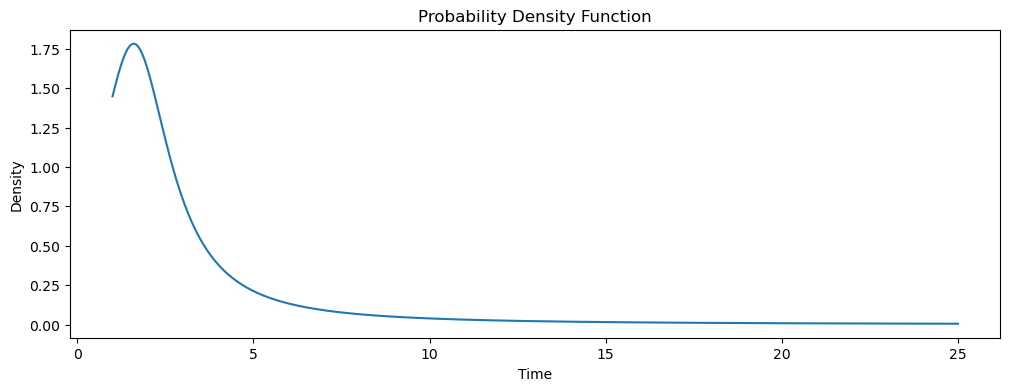

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mu = 1.6
sigma = 1.25
height = 7.
offset = -1.3

# Create time points
t = np.linspace(1, 25, 1000)

# Calculate PDF (derivative of CDF)
pdf = (height / (np.pi * sigma)) * (1 / (1 + ((t - mu)/sigma)**2))

# Plot PDF
plt.figure(figsize=(12, 4))
plt.plot(t, pdf)
plt.title('Probability Density Function')
plt.xlabel('Time')
plt.ylabel('Density')


Text(0.02, 0.98, 'Points shown: 10,000\nEntropy range: 0.000 to 6.112')

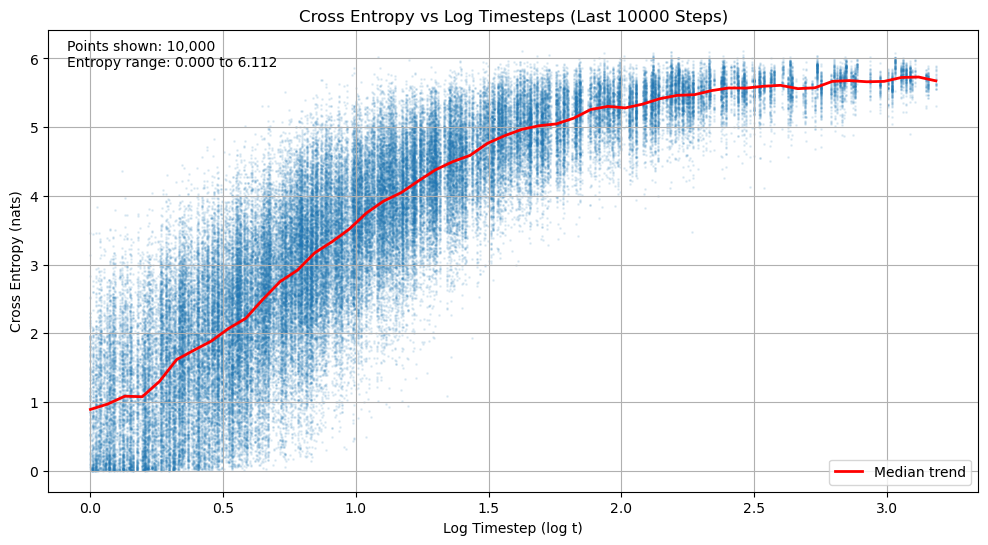

In [229]:
import matplotlib.pyplot as plt
import numpy as np

# Get last 10000 points
times = np.array(scheduler.times[-100000:])
entropy = np.array(scheduler.entropy[-100000:])

plt.figure(figsize=(12, 6))
plt.scatter(np.log(times), entropy, alpha=0.1, s=1)

# Trend line using log time bins
log_time_bins = np.linspace(np.log(times.min()), np.log(times.max()), 50)
entropy_means = [np.median(entropy[np.abs(np.log(times) - t) < (np.log(times.max())-np.log(times.min()))/50]) for t in log_time_bins]
plt.plot(log_time_bins, entropy_means, 'r-', linewidth=2, label='Median trend')

plt.title('Cross Entropy vs Log Timesteps (Last 10000 Steps)')
plt.xlabel('Log Timestep (log t)')
plt.ylabel('Cross Entropy (nats)')
plt.grid(True)
plt.legend()

plt.text(0.02, 0.98, f'Points shown: 10,000\nEntropy range: {entropy.min():.3f} to {entropy.max():.3f}', 
        transform=plt.gca().transAxes, verticalalignment='top')

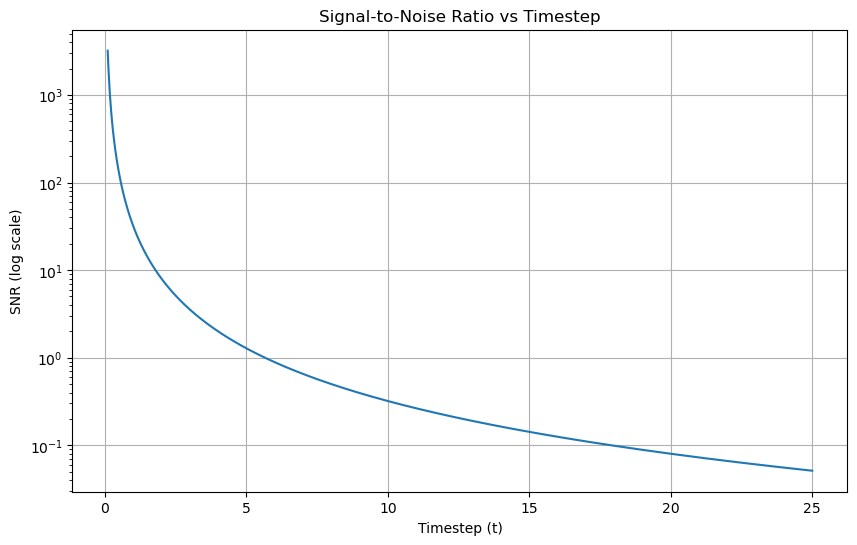

In [157]:
import numpy as np
import matplotlib.pyplot as plt

embed_dim = 32  # typical embedding dimension
t = np.linspace(0.1, 25, 1000)
snr = embed_dim/(t**2)

plt.figure(figsize=(10, 6))
plt.plot(t, snr)
plt.yscale('log')
plt.title('Signal-to-Noise Ratio vs Timestep')
plt.xlabel('Timestep (t)')
plt.ylabel('SNR (log scale)')
plt.grid(True)
plt.show()

In [216]:
def generate_sample(
    model,
    scheduler,
    batch_size=1,
    seq_len=10,
    n_steps=50,
    t_min=None,
    t_max=None,
    device="cuda"
):
    """
    Generate samples using a diffusion model with self-conditioning.
    
    Args:
        model: The diffusion model
        scheduler: Timestep scheduler
        batch_size: Number of samples to generate in parallel
        seq_len: Length of each generated sequence
        n_steps: Number of diffusion steps
        t_min: Minimum timestep value
        t_max: Maximum timestep value
        device: Device to run generation on
        
    Returns:
        predicted_tokens: Generated token indices of shape (batch_size, seq_len)
    """
    emb_dim = model.embedding.embedding_dim
    
    # Get timesteps as a 1D sequence
    timesteps = scheduler.make_timesteps(
        n_steps,
        tmin=t_min,
        tmax=t_max,
        device=device
    )
    
    # Initialize noise
    image = torch.randn(batch_size, seq_len, emb_dim, device=device) * timesteps[0]

    # Reset self-conditioning state
    model.self_conditioner.prev_preds = None
    p_embeddings = torch.zeros_like(image)

    for i in range(len(timesteps) - 1):
        with torch.no_grad():
            # Concatenate residual stream with conditioning
            x = torch.cat([image, p_embeddings], dim=-1)
            c_in = 1 / torch.sqrt(timesteps[i].unsqueeze(0)**2 + 1) #normalization factor
            x = x * c_in

            # Forward through model components
            x = model.input_proj(x)
            
            c_noise = torch.log(timesteps[i].unsqueeze(0)) / 4
            time_emb = model.time_embedding(c_noise)
            
            for block in model.transformer_blocks:
                x = block(x, time_emb)
            
            logits = model.output_proj(x)

        model.self_conditioner.update_prev_preds(logits)

        probs = torch.softmax(logits, dim=-1)
        # Get expected embeddings for next residual
        expected_embedding = torch.matmul(probs, model.embedding.normalized_embeddings)

        # Update conditioning for next step
        p_embeddings = model.self_conditioner.get_self_conditioning(
            x, model, timesteps[i+1], training=False
        )

        # Compute derivative and update residual stream
        d = (image - expected_embedding) / timesteps[i] 
        dt = timesteps[i + 1] - timesteps[i]
        image = image + dt * d

    # Final forward pass
    with torch.no_grad():
        x = torch.cat([image, p_embeddings], dim=-1)
        x = model.input_proj(x)
        c_noise = torch.log(timesteps[-1].unsqueeze(0)) / 4
        time_emb = model.time_embedding(c_noise)

        for block in model.transformer_blocks:
            x = block(x, time_emb)
            
        final_logits = model.output_proj(x)

    predicted_tokens = torch.argmax(final_logits, dim=2)
    
    return predicted_tokens


def generate_unique_samples(
    model,
    scheduler,
    num_samples,
    lmin=5,
    lmax=10,
    n_steps=50,
    t_min=None,
    t_max=None,
    device="cuda"
):
    """
    Generate multiple samples with varying lengths and deduplicate tokens within each sequence.
    
    Args:
        model: The diffusion model
        scheduler: Timestep scheduler
        num_samples: Number of samples to generate
        lmin: Minimum sequence length
        lmax: Maximum sequence length
        n_steps: Number of diffusion steps
        t_min: Minimum timestep value
        t_max: Maximum timestep value
        device: Device to run generation on
        
    Returns:
        list[list[int]]: List of sequences, where each sequence contains unique tokens
    """
    unique_sequences = []
    
    for _ in range(num_samples):
        # Sample a random sequence length
        seq_len = torch.randint(low=lmin, high=lmax+1, size=(1,)).item()
        
        # Generate a single sample
        tokens = generate_sample(
            model,
            scheduler,
            batch_size=1,
            seq_len=seq_len,
            n_steps=n_steps,
            t_min=t_min,
            t_max=t_max,
            device=device
        )
        
        # Convert to list and get first sequence
        token_list = tokens[0].cpu().tolist()
        
        # Deduplicate while preserving order
        seen = set()
        unique_tokens = []
        for token in token_list:
            if token not in seen:
                seen.add(token)
                unique_tokens.append(token)
        
        unique_sequences.append(unique_tokens)
    
    return unique_sequences




In [217]:
tokens = generate_sample(
    model,
    scheduler,
    batch_size=3,
    seq_len=15,
    n_steps=50,
    t_min=1,
    t_max=25,
    device=device
)

In [236]:
sequences = generate_unique_samples(
    model,
    scheduler,
    num_samples=200,
    lmin=5,   # Minimum sequence length
    lmax=200,  # Maximum sequence length
    n_steps=50,
    t_min=1,
    t_max=25,
    device=device
)


/mnt/mnemo7/mpelus/miniconda3/envs/matlas/lib/python3.12/site-packages/sklearn/metrics/pairwise.py:2361: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/mnt/mnemo7/mpelus/miniconda3/envs/matlas/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


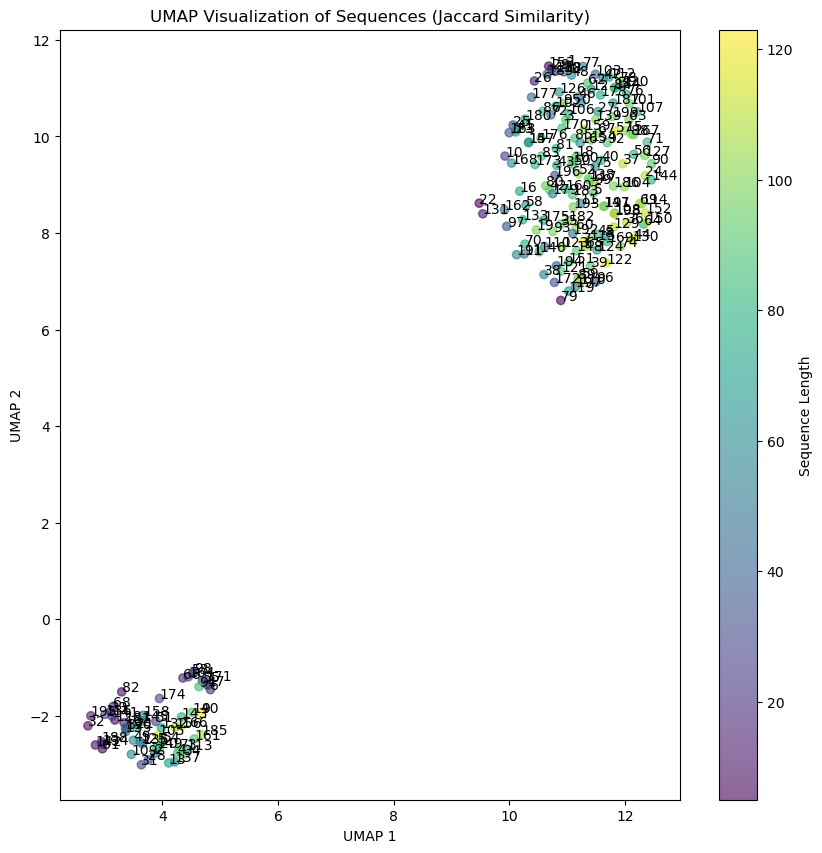

In [239]:
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

# Binarize sequences
vocab_size = 519
binary_vecs = np.zeros((len(sequences), vocab_size))
for i, seq in enumerate(sequences):
    binary_vecs[i, seq] = 1

# Compute Jaccard distances
distances = pairwise_distances(binary_vecs, metric='jaccard')

# Apply UMAP
umap = UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric='precomputed'
)
embeddings = umap.fit_transform(distances)

# Create plot
plt.figure(figsize=(10, 10))
scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], 
                     c=[len(seq) for seq in sequences],
                     cmap='viridis',
                     alpha=0.6)

# Add sequence labels
for i, seq in enumerate(sequences):
    plt.annotate(f'{i}', (embeddings[i, 0], embeddings[i, 1]))

plt.colorbar(scatter, label='Sequence Length')
plt.title('UMAP Visualization of Sequences (Jaccard Similarity)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

tensor([25.0000, 19.1791, 15.6738, 13.3299, 11.6512, 10.3889,  9.4044,  8.6145,
         7.9663,  7.4244,  6.9643,  6.5685,  6.2241,  5.9216,  5.6535,  5.4140,
         5.1987,  5.0040,  4.8269,  4.6649,  4.5162,  4.3790,  4.2519,  4.1339,
         4.0239,  3.9209,  3.8243,  3.7335,  3.6479,  3.5669,  3.4902,  3.4173,
         3.3480,  3.2819,  3.2188,  3.1583,  3.1004,  3.0448,  2.9914,  2.9399,
         2.8902,  2.8422,  2.7958,  2.7509,  2.7073,  2.6650,  2.6238,  2.5838,
         2.5448,  2.5068,  2.4696,  2.4333,  2.3978,  2.3630,  2.3289,  2.2954,
         2.2625,  2.2302,  2.1984,  2.1670,  2.1361,  2.1056,  2.0755,  2.0458,
         2.0163,  1.9872,  1.9583,  1.9296,  1.9012,  1.8729,  1.8448,  1.8169,
         1.7891,  1.7613,  1.7337,  1.7061,  1.6785,  1.6509,  1.6234,  1.5958,
         1.5681,  1.5404,  1.5125,  1.4846,  1.4565,  1.4282,  1.3998,  1.3711,
         1.3422,  1.3130,  1.2835,  1.2537,  1.2236,  1.1930,  1.1621,  1.1307,
         1.0988,  1.0665,  1.0335,  1.00

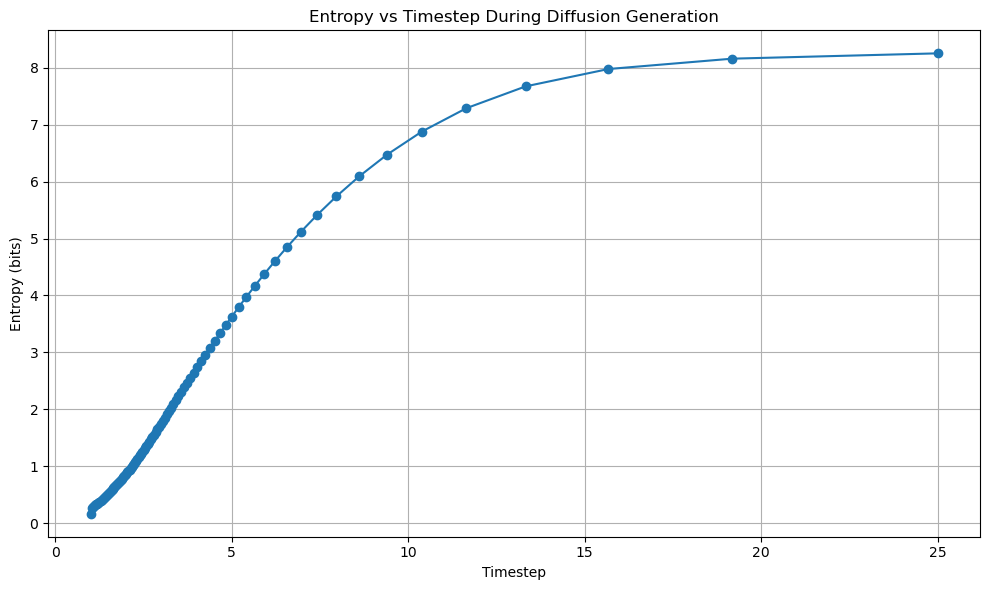

In [232]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_entropy_vs_timesteps(
    model,
    scheduler,
    batch_size=1,
    seq_len=10,
    n_steps=50,
    t_min=None,
    t_max=None,
    device="cuda"
):
    """
    Generate samples and plot entropy against timesteps.
    
    Args:
        model: The diffusion model
        scheduler: Timestep scheduler
        batch_size: Number of samples to generate in parallel
        seq_len: Length of each generated sequence
        n_steps: Number of diffusion steps
        t_min: Minimum timestep value
        t_max: Maximum timestep value
        device: Device to run generation on
    """
    emb_dim = model.embedding.embedding_dim
    
    # Get timesteps
    timesteps = scheduler.make_timesteps(
        n_steps,
        tmin=t_min,
        tmax=t_max,
        device=device
    )
    print(timesteps)
    
    # Initialize storage for entropy values
    entropy_values = []
    timestep_values = []
    
    # Initialize noise
    image = torch.randn(batch_size, seq_len, emb_dim, device=device) * timesteps[0]
    
    # Reset self-conditioning state
    model.self_conditioner.prev_preds = None
    p_embeddings = torch.zeros_like(image)

    def calculate_entropy(probs):
        """Calculate entropy from probability distribution"""
        # Add small epsilon to avoid log(0)
        eps = 1e-10
        entropy = -torch.sum(probs * torch.log2(probs + eps), dim=-1)
        return entropy.mean().item()

    for i in range(len(timesteps) - 1):
        with torch.no_grad():
            x = torch.cat([image, p_embeddings], dim=-1)
            c_in = 1 / torch.sqrt(timesteps[i].unsqueeze(0)**2 + 1)
            x = x * c_in

            x = model.input_proj(x)
            
            c_noise = torch.log(timesteps[i].unsqueeze(0)) / 4
            time_emb = model.time_embedding(c_noise)
            
            for block in model.transformer_blocks:
                x = block(x, time_emb)
            
            logits = model.output_proj(x)

        model.self_conditioner.update_prev_preds(logits)
        
        # Calculate probabilities and entropy
        probs = torch.softmax(logits, dim=-1)
        entropy = calculate_entropy(probs)
        
        # Store values for plotting
        entropy_values.append(entropy)
        timestep_values.append(timesteps[i].item())

        # Get expected embeddings for next residual
        expected_embedding = torch.matmul(probs, model.embedding.normalized_embeddings)
        
        p_embeddings = model.self_conditioner.get_self_conditioning(
            x, model, timesteps[i+1], training=False
        )

        d = (image - expected_embedding) / timesteps[i]**2
        dt = timesteps[i + 1] - timesteps[i]
        image = image + dt * d

    # Calculate final entropy
    with torch.no_grad():
        x = torch.cat([image, p_embeddings], dim=-1)
        x = model.input_proj(x)
        c_noise = torch.log(timesteps[-1].unsqueeze(0)) / 4
        time_emb = model.time_embedding(c_noise)

        for block in model.transformer_blocks:
            x = block(x, time_emb)
            
        final_logits = model.output_proj(x)
        final_probs = torch.softmax(final_logits, dim=-1)
        final_entropy = calculate_entropy(final_probs)

    entropy_values.append(final_entropy)
    timestep_values.append(timesteps[-1].item())

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(timestep_values, entropy_values, '-o')
    plt.xlabel('Timestep')
    plt.ylabel('Entropy (bits)')
    plt.title('Entropy vs Timestep During Diffusion Generation')
    plt.grid(True)
    
    
    plt.tight_layout()
    plt.show()
    
    return entropy_values, timestep_values

entropy_values, timestep_values = plot_entropy_vs_timesteps(
    model,
    scheduler,
    batch_size=1,
    seq_len=200,
    n_steps=100
)
